In [2]:
pip install transformers

     |████████████████████████████████| 2.3MB 29.3MB/s 
     |████████████████████████████████| 3.3MB 49.7MB/s 
     |████████████████████████████████| 901kB 46.4MB/s 


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [4]:
!gdown --id 1rVa7buu3F_Vtq1-c7u9Qauqc679jlcfj
!gdown --id 1tMXP9mBk98PCmI0ltmHzNHPrdr46TJkZ

Downloading...
From: https://drive.google.com/uc?id=1rVa7buu3F_Vtq1-c7u9Qauqc679jlcfj
To: /content/info_apps.csv
100% 9.00k/9.00k [00:00<00:00, 8.40MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tMXP9mBk98PCmI0ltmHzNHPrdr46TJkZ
To: /content/apps_review_tiktok-nonrating.csv
100% 895k/895k [00:00<00:00, 14.2MB/s]


In [5]:
df = pd.read_csv('./data/review_apps/apps_review_tiktok-nonrating.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEaxCuEU61SHHaTHDs-GydVhgd4rWOIwMDUgat...,Dapur Mama Hoshi,https://play-lh.googleusercontent.com/a/AATXAJ...,Aplikasinya sebenarnya bagus..Tp knp skrg sy m...,1,40,19.5.43,2021-05-28 13:20:53,NaN,NaN,most_relevant,com.ss.android.ugc.trill
1,gp:AOqpTOFTLjgAcC2zQ2D3ZzHVdnqBqjVgpqXo9h-bdYi...,Luluk Muawalah,https://play-lh.googleusercontent.com/a/AATXAJ...,"Tolong kepada pihak tiktok, kenapa tiba2 saya ...",1,23,19.5.43,2021-05-27 23:15:58,NaN,NaN,most_relevant,com.ss.android.ugc.trill
2,gp:AOqpTOE6ScCvmXVBy1lRWOkmbYo68Z2dbNwPYF2kvR_...,Marcelino Laoh,https://play-lh.googleusercontent.com/a/AATXAJ...,Saya sangat kecewa kepada pihak tiktok akun sa...,1,9,19.5.43,2021-05-28 20:45:01,NaN,NaN,most_relevant,com.ss.android.ugc.trill
3,gp:AOqpTOFkctHg8Z8qjrxGcwAgFyYtCSCxeXkPX7olSS7...,Ni Putu Dian M. Dewi,https://play-lh.googleusercontent.com/a-/AOh14...,Jujur ni ya gue gak puas banget sama tiktok se...,1,6,19.5.43,2021-05-29 07:32:08,NaN,NaN,most_relevant,com.ss.android.ugc.trill
4,gp:AOqpTOGVXq7aRXCxIdeYO7Gs09rbtiZEqSbgfRyjmNW...,Aat Safaat,https://play-lh.googleusercontent.com/a-/AOh14...,Aplikasi Haram!!!!!!!!!!!!!!!!!!!!!!!!! ¡!¡!!!...,1,4,19.5.43,2021-05-28 16:15:16,NaN,NaN,most_relevant,com.ss.android.ugc.trill


In [6]:
df.shape

(2200, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              2200 non-null   object
 1   userName              2200 non-null   object
 2   userImage             2200 non-null   object
 3   content               2200 non-null   object
 4   score                 2200 non-null   int64 
 5   thumbsUpCount         2200 non-null   int64 
 6   reviewCreatedVersion  1723 non-null   object
 7   at                    2200 non-null   object
 8   replyContent          1 non-null      object
 9   repliedAt             1 non-null      object
 10  sortOrder             2200 non-null   object
 11  appId                 2200 non-null   object
dtypes: int64(2), object(10)
memory usage: 206.4+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'review score')

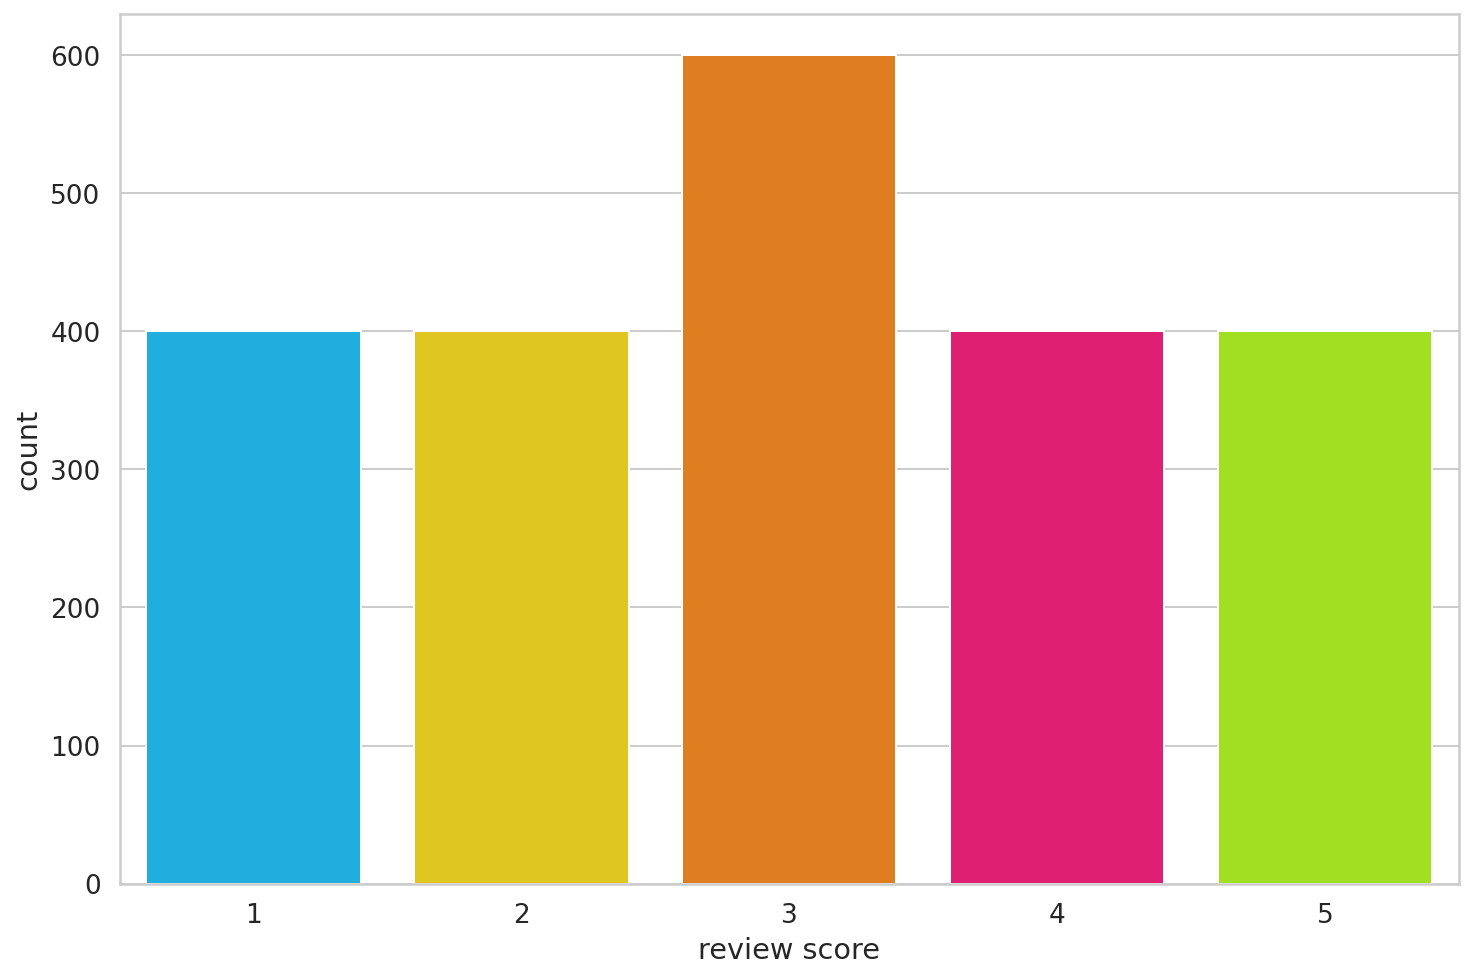

In [8]:
sns.countplot(df.score)
plt.xlabel('review score')

In [9]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <=2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

In [10]:
df['sentiment'] = df.score.apply(to_sentiment)

In [11]:
class_names = ['negative','neutral','positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


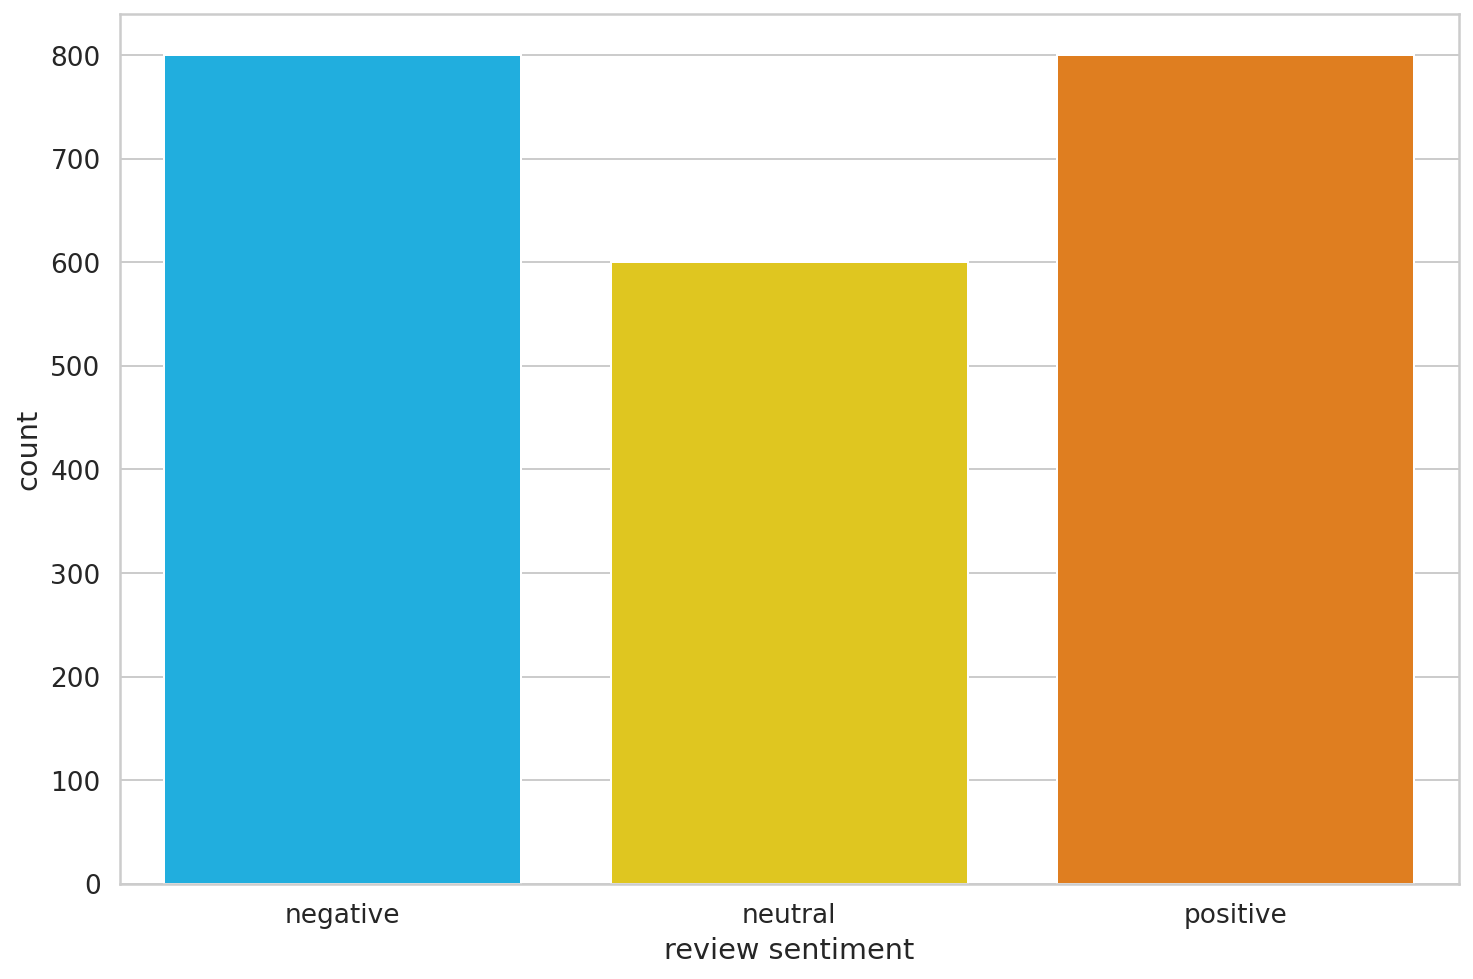

In [12]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

### Data Cleaning
continue in file google colab

### Data Preprocessing

In [13]:
from transformers import BertTokenizer, BertModel

model_name='cahya/bert-base-indonesian-522M'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [48]:
text = 'saya pergi ke pasar bersama teman teman ingin membeli makan ayam, kamu mau?'

In [49]:
tokens = tokenizer.tokenize(text)

In [50]:
print(len(tokens))
print(tokens)

15
['saya', 'pergi', 'ke', 'pasar', 'bersama', 'teman', 'teman', 'ingin', 'membeli', 'makan', 'ayam', ',', 'kamu', 'mau', '?']


In [51]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [52]:
print(len(token_ids))
print(token_ids)

15
[3245, 3648, 1519, 3374, 2066, 3921, 3921, 3336, 5526, 2464, 6281, 15, 8343, 5481, 32]


##### sentence tokenizer

In [53]:
tokens = tokenizer.tokenize(text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {text}')
print(f' Tokens: {tokens}')
print(f' Tokens IDs: {token_ids}')

 Sentence: saya pergi ke pasar bersama teman teman ingin membeli makan ayam, kamu mau?
 Tokens: ['saya', 'pergi', 'ke', 'pasar', 'bersama', 'teman', 'teman', 'ingin', 'membeli', 'makan', 'ayam', ',', 'kamu', 'mau', '?']
 Tokens IDs: [3245, 3648, 1519, 3374, 2066, 3921, 3921, 3336, 5526, 2464, 6281, 15, 8343, 5481, 32]


### Special Tokens

In [54]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 1)

In [55]:
tokenizer.cls_token, tokenizer.sep_token_id

('[CLS]', 1)

In [56]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 2)

In [57]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 0)

In [58]:
encoding = tokenizer.encode_plus(
    text,
    max_length=32,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt' # Return PyTorch tensors
)

encoding.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [59]:
encoding['input_ids']

tensor([[   3, 3245, 3648, 1519, 3374, 2066, 3921, 3921, 3336, 5526, 2464, 6281,
           15, 8343, 5481,   32,    1,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    2,    2,    2,    2]])

In [60]:
len(encoding['input_ids'][0])

32

In [61]:
encoding["attention_mask"]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [62]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'saya',
 'pergi',
 'ke',
 'pasar',
 'bersama',
 'teman',
 'teman',
 'ingin',
 'membeli',
 'makan',
 'ayam',
 ',',
 'kamu',
 'mau',
 '?',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### choosing sequence length

In [63]:
token_lens = []

for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

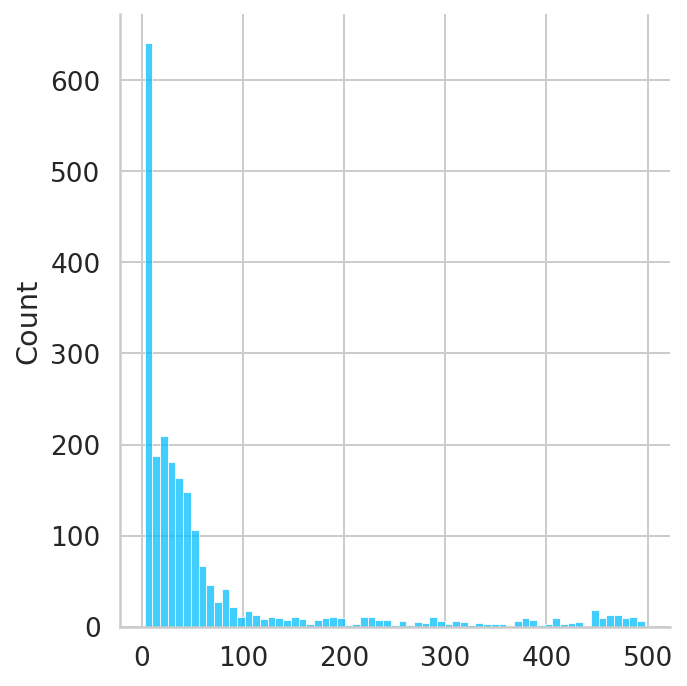

In [64]:
sns.displot(token_lens);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


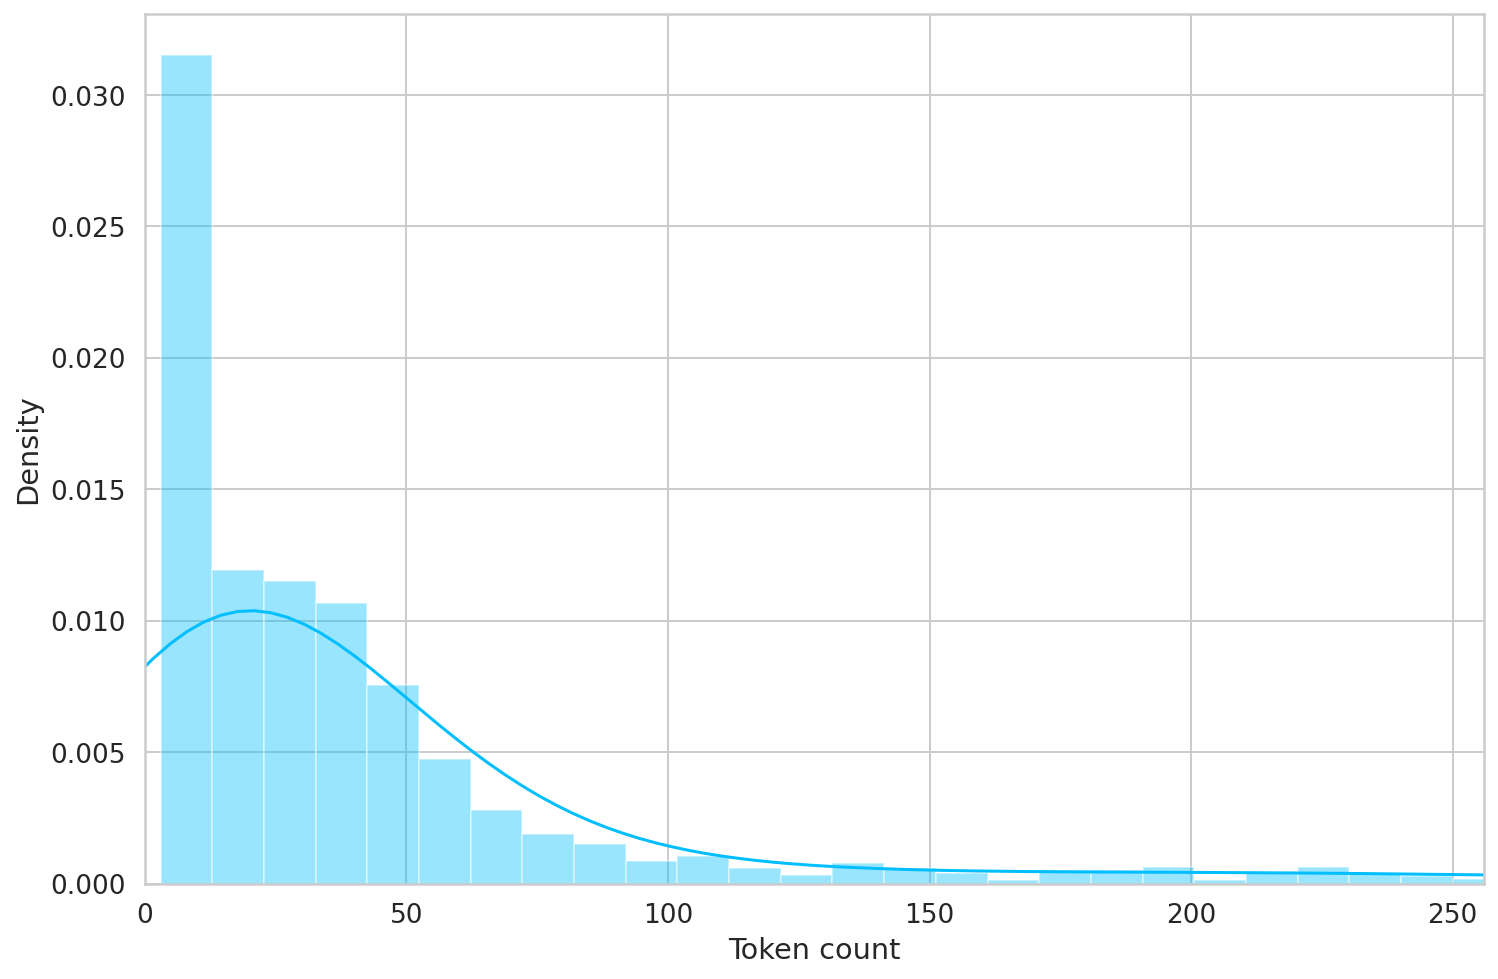

In [65]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [66]:
# Most of the reviews seem to contain less than 32 tokens, but we’ll be on the safe side and choose a maximum length of 64.

MAX_LEN = 64
# BATCH_SIZE = 8
# EPOCHS = 20

In [67]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)
    
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [68]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

In [69]:
df_train.shape, df_val.shape, df_test.shape

((1760, 13), (220, 13), (220, 13))

In [70]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
    )

In [71]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [73]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [74]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 64])
torch.Size([16, 64])
torch.Size([16])
